# Linear Regression, kNN Regression, and Inference

[Resource](https://harvard-iacs.github.io/2018-CS109A/lectures/lecture-4/)

# Part 1: Load Basic Python Modules

In [2]:
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df_adv = pd.read_csv("../data/Advertising.csv")

Now get a subset of the data:

In [4]:
data_x = df_adv.TV[5:13]
data_y = df_adv.sales[5:13]

In [5]:
data_x

5       8.7
6      57.5
7     120.2
8       8.6
9     199.8
10     66.1
11    214.7
12     23.8
Name: TV, dtype: float64

# Part 3: Sort the Data

We need to sort the data in order to apply the KNN algorithm.

In [6]:
idx = np.argsort(data_x).values # Get indices ordered from lowest to highest values
idx

array([3, 0, 7, 1, 5, 2, 4, 6])

Remember that the above output are the indices from `data_x`, not the indices from `df_adv`.

In [7]:
# Get the actual data in the order from above
data_x = data_x.iloc[idx]
data_y = data_y.iloc[idx]

In [8]:
data_x

8       8.6
5       8.7
12     23.8
6      57.5
10     66.1
7     120.2
9     199.8
11    214.7
Name: TV, dtype: float64

In [9]:
data_y

8      4.8
5      7.2
12     9.2
6     11.8
10     8.6
7     13.2
9     10.6
11    17.4
Name: sales, dtype: float64

Now here's a function that finds the index of the nearest neighbor and returns the value of the nearest neighbor. Note that this is just for k=1 and the distance function is simply the absolute value.

In [10]:
def find_nearest(array, value):
    idx = (np.abs(array-value)).idxmin()
    return idx, array[idx]

Note that we've used the `idxmin` method in our function. This is because `array` is a pandas dataframe and `idxmin()` is designed to work with pandas dataframes. If we are working with a numpy array then the appropriate method would be `argmin()`.

In [11]:
# Create some artificial x-values
x = np.linspace(np.min(data_x), np.max(data_x))

# Initialize the y-values to zero
y = np.zeros((len(x)))

Apply the KNN algorithm. Try to predict the y-value at a given x-value.

Note: You may have tried to use the `range` method in your code before. Enumerate is far better in this case. Look up `range` vs. `enumerate` and you will see why.

In [12]:
for i, xi in enumerate(x):
    y[i] = data_y[find_nearest(data_x, xi)[0]]

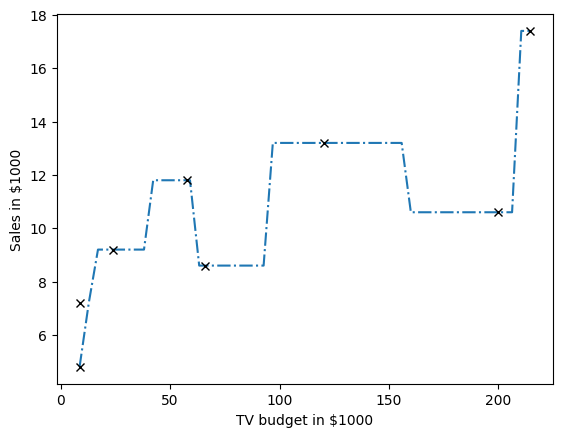

In [13]:
# Plot the solution
plt.plot(x, y, "-.")

# Plot the original data using black x's
plt.plot(df_adv.TV[5:13], df_adv.sales[5:13], "kx")
plt.title('')
plt.xlabel("TV budget in $1000")
plt.ylabel("Sales in $1000");

Now let's move onto the actual example.

# Prediction using kNN and Linear Regression

[Resource](https://harvard-iacs.github.io/2018-CS109A/sections/section-2/solutions/)

For this section, our goal is to get you familiarized with k-Nearest Neighbors and Linear. These methods find powerful applications in all walks of life and are centered around prediction.

Specifically, we will:

1. Review Basic Python Data Structures
2. Import Data and Manipulates Rows and Columns
3. Load in the Bikeshare dataset which is split into a training and testing dataset
3. Do some basic exploratory analysis of the dataset and go through a scatterplot
5. Write out the algorithm for kNN WITH AND WITHOUT using the sklearn package
6. Learn to use the sklearn package for Linear Regression.
7. What is and how to extract information about Confidence Intervals.

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Regression imports
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS
import statsmodels.api as sm

# Metrics, performance evaluation, and helpful functions
from sklearn import metrics, datasets
from collections import Counter
from sklearn.model_selection import train_test_split

# Aesthetic settings
from IPython.display import display
pd.set_option('display.max_rows', 999)
pd.set_option('display.width', 500)
pd.set_option('display.notebook_repr_html', True)

# Load in the Bikeshare dataset and perform EDA

The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.

Here's an overview of the data:
* season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
* month (1 through 12, with 1 denoting Jan)
* holiday (1 = the day is a holiday, 0 = otherwise)
* day_of_week (0 through 6, with 0 denoting Sunday)
* workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
* weather
    1. Clear, Few clouds, Partly cloudy, Partly cloudy
    2. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3. Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    4. Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp (temperature in Celsius)
* atemp (apparent temperature, or relative outdoor temperature, in Celsius)
* humidity (relative humidity)
* windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.

In [15]:
bikeshare = pd.read_csv("../data/bikeshare.csv")
del bikeshare["Unnamed: 0"]
print("Length of Dataset:", len(bikeshare))
bikeshare.head()

Length of Dataset: 731


,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,0.118167,6073.0
1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,0.174129,6606.0
2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,0.253733,7363.0
3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,0.169779,2431.0
4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,0.097021,1996.0


In [16]:
bikeshare.describe()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,6.519836,0.028728,2.997264,0.683995,1.395349,16.229822,18.885089,62.789406,0.190486,4552.354309
std,1.110807,3.451913,0.167155,2.004787,0.465233,0.544894,11.531101,10.278475,14.242910,0.077498,2021.971365
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-11.000000,-6.000000,0.000000,0.022392,22.000000
25%,2.000000,4.000000,0.000000,1.000000,0.000000,1.000000,6.000000,10.000000,52.000000,0.134950,3116.000000
50%,3.000000,7.000000,0.000000,3.000000,1.000000,1.000000,16.000000,20.000000,62.666700,0.180975,4575.000000
75%,3.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.000000,27.000000,73.020850,0.233214,6048.000000
max,4.000000,12.000000,1.000000,6.000000,1.000000,3.000000,39.000000,42.000000,97.250000,0.507463,10045.000000


We can also use the `groupby` function to look at mean stats aggregated by month:

In [17]:
bikeshare.groupby("month").mean()

,season,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
month,,,,,,,,,,
1.0,1.000000,0.048387,2.870968,0.645161,1.419355,-0.080645,4.145161,58.582827,0.206303,2498.306452
2.0,1.000000,0.035088,3.000000,0.684211,1.368421,3.912281,7.807018,56.746468,0.215684,2824.315789
3.0,1.354839,0.000000,3.096774,0.725806,1.451613,9.580645,13.080645,58.847503,0.222699,3822.241935
4.0,2.000000,0.033333,3.000000,0.666667,1.416667,14.583333,17.783333,58.806312,0.234482,4348.600000
5.0,2.000000,0.032258,2.903226,0.693548,1.403226,22.532258,24.661290,68.895831,0.182989,5268.790323
6.0,2.333333,0.000000,3.100000,0.716667,1.233333,28.150000,29.216667,57.580552,0.185420,5547.033333
7.0,3.000000,0.032258,2.935484,0.661290,1.193548,32.580645,33.338710,59.787632,0.166059,5563.677419
8.0,3.000000,0.000000,3.000000,0.741935,1.306452,29.629032,30.096774,63.773010,0.172918,5584.887097
9.0,3.266667,0.033333,3.050000,0.666667,1.500000,23.850000,25.466667,71.471437,0.165945,5653.316667


Let's plot the variation of the count with month. Is there a seasonal change?

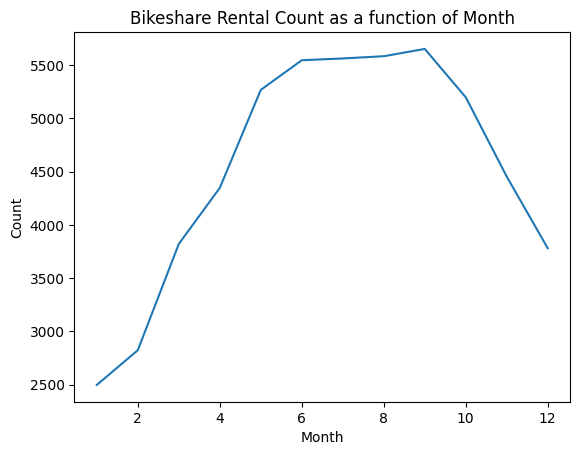

In [18]:
plt.plot(bikeshare.groupby("month").mean()["count"])
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Bikeshare Rental Count as a function of Month")
plt.show()

What is temp, a_temp, is there a difference?

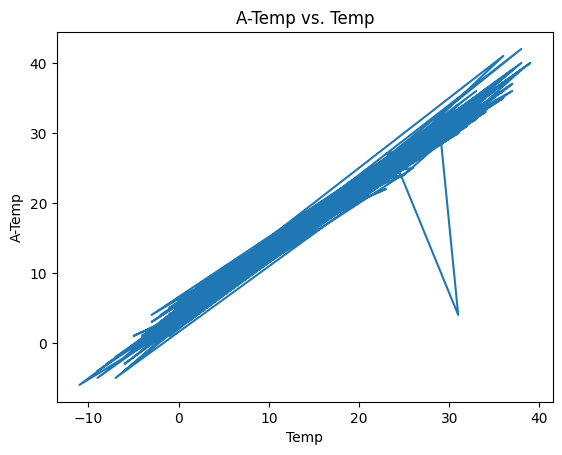

In [19]:
plt.plot(bikeshare["temp"], bikeshare["atemp"])
plt.xlabel("Temp")
plt.ylabel("A-Temp")
plt.title("A-Temp vs. Temp")
plt.show()

**What did we do wrong here? Why does the plot look like this?**

Sorting! Whenever your plot makes zig-zag changes across the scale, it's because `matplotlib` is trying to connect the points sequentially from the top (using a line plot) and skipping across the scale when x of i+1 if lower than x of i. So let's sort.

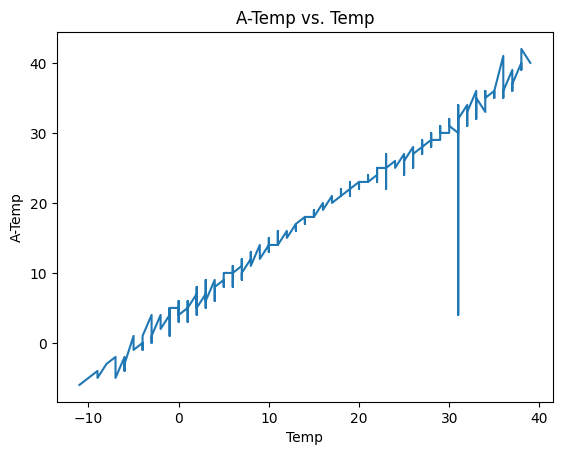

In [20]:
new = bikeshare.sort_values(['temp'])
plt.plot(new['temp'], new["atemp"])
plt.xlabel("Temp")
plt.ylabel("A-Temp")
plt.title("A-Temp vs. Temp")
plt.show()

**It still looks weird, why?**

Let's have a closer look at the dataframe:

In [21]:
new.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
176,1.0,1.0,0.0,6.0,0.0,1.0,-11.0,-6.0,40.0000,0.171970,981.0
367,1.0,1.0,0.0,1.0,1.0,1.0,-9.0,-4.0,49.1739,0.158330,1416.0
265,1.0,1.0,0.0,0.0,0.0,1.0,-9.0,-5.0,43.6522,0.246600,986.0
346,1.0,1.0,0.0,3.0,1.0,2.0,-8.0,-3.0,41.4583,0.184700,2368.0
612,1.0,2.0,0.0,3.0,1.0,2.0,-7.0,-2.0,49.4783,0.188839,1605.0


There are multiple `atemp` values for each `temp` value, which if not sorted will bounce around at the same x-value. Thus, we need to sort both axes simultaneously.

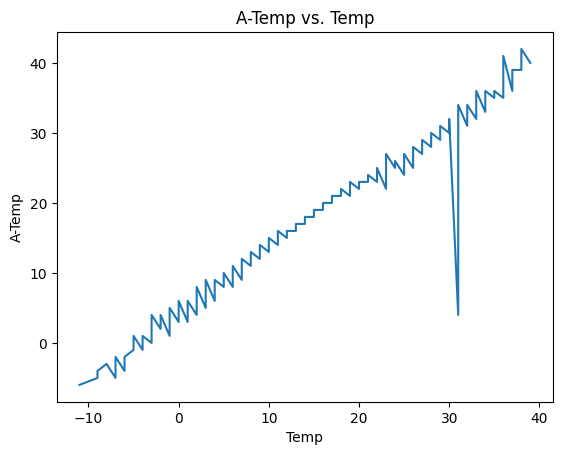

In [22]:
new = bikeshare.sort_values(["temp", "atemp"])
plt.plot(new["temp"], new["atemp"])
plt.xlabel("Temp")
plt.ylabel("A-Temp")
plt.title("A-Temp vs. Temp")
plt.show()

By plotting efficiently, we've found an anomaly we would've otherwise overlooked. **It looks like there is a problem with the data around temp greater than 30 and atemp less than 10**.

In [23]:
(bikeshare[(bikeshare['temp']>30) & (bikeshare['atemp']<10)])

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
188,3.0,8.0,0.0,5.0,1.0,1.0,31.0,4.0,57.0833,0.231354,7148.0


Anomaly! `atemp` and `temp` are usually linearly related except at this one datapoint. Now, we get to make a judgement call as to whether we should keep the data point. We'll come back to this question after the lecture on Missing Data and Imputation. Worth a thought though.

In [24]:
bikeshare = bikeshare.drop([188])
display(bikeshare[(bikeshare["temp"] > 30) & (bikeshare["atemp"] < 10)])

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count


## Normalize

In general, it's good practice to normalize data before proceeding. As such, we can create the following functions:

In [25]:
def normalize(x):
    num = x - np.min(x)
    denom = np.max(x) - np.min(x)
    return (num/denom)

bikeshare_norm = normalize(bikeshare)
bikeshare_norm.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,0.001293,0.001591,0.001094,0.001293,0.001193,0.001293,0.003481,0.003679,0.008710,0.001106,0.605012
1,0.001492,0.002287,0.001094,0.001293,0.001193,0.001193,0.002586,0.002983,0.008391,0.001111,0.658015
2,0.001293,0.001691,0.001094,0.001492,0.001193,0.001193,0.003679,0.003878,0.006758,0.001119,0.733294
3,0.001492,0.002287,0.001094,0.001094,0.001094,0.001193,0.001094,0.001492,0.006924,0.001111,0.242840
4,0.001392,0.001989,0.001094,0.001392,0.001193,0.001392,0.003381,0.003381,0.010214,0.001104,0.199582


In [26]:
bikeshare_norm.describe()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.001342,0.001742,0.001097,0.001392,0.001162,0.001233,0.002706,0.002974,0.007339,0.001113,0.453441
std,0.000111,0.000343,0.000017,0.000199,0.000046,0.000054,0.001146,0.001021,0.001417,0.000008,0.200981
min,0.001193,0.001193,0.001094,0.001094,0.001094,0.001193,0.000000,0.000497,0.001094,0.001096,0.003282
25%,0.001293,0.001492,0.001094,0.001193,0.001094,0.001193,0.001691,0.002088,0.006265,0.001107,0.310909
50%,0.001342,0.001790,0.001094,0.001392,0.001193,0.001193,0.002685,0.003083,0.007330,0.001112,0.455798
75%,0.001392,0.002088,0.001094,0.001591,0.001193,0.001293,0.003679,0.003779,0.008356,0.001117,0.602029
max,0.001492,0.002287,0.001193,0.001691,0.001193,0.001392,0.004972,0.005270,0.010765,0.001144,1.000000


In [27]:
def split_data(data):
    length = len(data)
    split = 0.7

    # Set random seed for shuffling
    np.random.seed(9001)

    # Generate a mask with a X:Y split
    mask = np.random.rand(length) < split
    
    data_train = data[mask]
    data_test = data[~mask]

    return data_train, data_test

In [28]:
# Adapt the normalization function to take column names as input

def normalize_cols(x, columns):
    for i in columns: x[i] = normalize(x[i])
    return x

bikeshare_norm2 = normalize_cols(bikeshare, bikeshare.columns)

In [29]:
bikeshare_norm2.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,0.333333,0.363636,0.0,0.333333,1.0,0.5,0.70,0.666667,0.787489,0.197445,0.603711
1,1.000000,1.000000,0.0,0.333333,1.0,0.0,0.52,0.520833,0.754499,0.312814,0.656889
2,0.333333,0.454545,0.0,0.666667,1.0,0.0,0.74,0.708333,0.585689,0.476922,0.732415
3,1.000000,1.000000,0.0,0.000000,0.0,0.0,0.22,0.208333,0.602828,0.303846,0.240347
4,0.666667,0.727273,0.0,0.500000,1.0,1.0,0.68,0.604167,0.943016,0.153852,0.196947


In [30]:
bikeshare.describe

<bound method NDFrame.describe of        season     month  holiday  day_of_week  workingday  weather  temp     atemp  humidity  windspeed     count
0    0.333333  0.363636      0.0     0.333333         1.0      0.5  0.70  0.666667  0.787489   0.197445  0.603711
1    1.000000  1.000000      0.0     0.333333         1.0      0.0  0.52  0.520833  0.754499   0.312814  0.656889
2    0.333333  0.454545      0.0     0.666667         1.0      0.0  0.74  0.708333  0.585689   0.476922  0.732415
3    1.000000  1.000000      0.0     0.000000         0.0      0.0  0.22  0.208333  0.602828   0.303846  0.240347
4    0.666667  0.727273      0.0     0.500000         1.0      1.0  0.68  0.604167  0.943016   0.153852  0.196947
5    0.333333  0.363636      0.0     0.333333         1.0      0.5  0.70  0.666667  0.716795   0.660264  0.441884
6    1.000000  0.909091      0.0     0.666667         1.0      0.0  0.36  0.354167  0.342908   0.670918  0.528085
7    0.333333  0.454545      0.0     0.333333         

# Broadcasting

From [Numpy's documentation](https://numpy.org/doc/stable/user/basics.broadcasting.html):

The term broadcasting describes how NumPy treats arrays with different shapes during arithmetic operations. Subject to certain constraints, the smaller array is “broadcast” across the larger array so that they have compatible shapes. Broadcasting provides a means of vectorizing array operations so that looping occurs in C instead of Python. 

# Choose one predictor

In [31]:
bikeshare.columns
bikeshare = bikeshare[["temp", "count"]]
bikeshare.head()

,temp,count
0,0.70,0.603711
1,0.52,0.656889
2,0.74,0.732415
3,0.22,0.240347
4,0.68,0.196947


# Split the data into a train and test set

Now that we have an idea of what the data looks like, we would like to predict the count. Therefore, we will be breaking up the data into a train and test set.

Let's first create a function that will randomly split the data up into a 70-30 split.

In [32]:
def split_data(data):
    length = len(data)
    split = 0.7
    np.random.seed(9001)
    mask = np.random.rand(length) < split

    data_train = data[mask]
    data_test = data[~mask]

    return data_train, data_test


In [35]:
train_data, test_data = split_data(bikeshare)
len(train_data), len(test_data)

(507, 223)

Now let's check that the ratio between the train and test data is correct:

In [47]:
len(test_data) / (len(test_data) + len(train_data))

0.30547945205479454

In [49]:
test_data.shape[0] / (test_data.shape[0] + train_data.shape[0])

0.30547945205479454

# Old vs. New Indices

Here I think the professor is also just showing the difference between `.loc` and `.iloc`.

In [50]:
train_data.head()

,temp,count
0,0.70,0.603711
3,0.22,0.240347
5,0.70,0.441884
6,0.36,0.528085
9,0.82,0.730819


In [51]:
train_data.iloc[:5]

,temp,count
0,0.70,0.603711
3,0.22,0.240347
5,0.70,0.441884
6,0.36,0.528085
9,0.82,0.730819


In [52]:
train_data.loc[3:9]

,temp,count
3,0.22,0.240347
5,0.70,0.441884
6,0.36,0.528085
9,0.82,0.730819


In [53]:
train_data.iloc[3:9]

,temp,count
6,0.36,0.528085
9,0.82,0.730819
12,0.26,0.218298
13,0.66,0.734511
14,0.46,0.434900
15,0.68,0.818617


# Splitting data using `train_test_split`

In [ ]:
train_data, test_data = train_test_split(bikeshare, test_size=0.3, random_state=13)
print(len(train_data), len(test_data))

511 219


In [58]:
train_data.shape[0] / (train_data.shape[0] + test_data.shape[0])

0.7